In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from torch.utils.data import Dataset,DataLoader
import cv2
from torchviz import make_dot
sun_data=pd.read_csv('../input/classes-sun/all_sun_cases.csv')
sun_data.head()

,Case,Size
0,1,6mm
1,2,18mm
2,3,3mm
3,4,4mm
4,5,3mm


#  One-vs Rest Multiclass Classification Approach
There are four classes:
1. C1 - 0-5mm
2. C2 - 5-10mm
3. C3 - 10-14mm
4. C4 - 14mm and above
The following models would be trained:
1. M1 : For classifying into C1 vs Rest
2. M2 : For classifying into C2 vs Rest
3. M3 : For classifying into C3 vs Rest
4. M4 : For classifying into C4 vs Rest

# **Training Model M3**
Dataset comprises of two classes:

1.C3 : Polyps with size between 10-14mm

2.Everything other than C3

In [28]:
root_dir='../input/bounding-boxes/Bounding Boxes/'
less_5=[]
rest=[]
for idx in range(sun_data.shape[0]):
    item=sun_data['Size'][idx] 
    item=item[:-2]
    item=int(item)
    if item<=5:
        less_5.append(root_dir+'case'+str(sun_data['Case'][idx]))
    else:
        rest.append(root_dir+'case'+str(sun_data['Case'][idx]))
    
print('Cases in Less 5mm : {}\nRest  : {}'.format(len(less_5),len(rest)))

Cases in Less 5mm : 60
Rest  : 40


In [29]:
#Images per case
less_5_images=0
rest_images=0
             
    
for idx in range(len(less_5)):
        try:
                images=os.listdir(less_5[idx])
                less_5_images+=(len(images))
        except:
                continue
for idx in range(len(rest)):
        try: 
                images=os.listdir(rest[idx])
                rest_images+=(len(images))
        except:
                continue
print('Less than 5mm images: {}\nRest images: {}'.format(less_5_images,rest_images))

Less than 5mm images: 23483
Rest images: 24766


In [30]:
less_5=[item.split('/')[4] for item in less_5]
rest=[item.split('/')[4] for item in rest]

# Model Architecture

In [31]:
#2D CNN:
import torch.nn as nn
class Net_2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,16,kernel_size=3,padding=1)
        self.batchnorm1=nn.BatchNorm2d(16)
        self.maxpool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(16,32,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.batchnorm2=nn.BatchNorm2d(64)
        self.relu=nn.ReLU(inplace=True)
        self.linear1=nn.Linear(28*28*64,128)
        self.linear2=nn.Linear(128,256)
        self.linear4=nn.Linear(256,512)
        self.linear3=nn.Linear(512,1)
        self.dropout=nn.Dropout(p=0.5)
    def forward(self,x):
        out=self.conv1(x)
        out=self.batchnorm1(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.conv2(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.conv3(out)
        out=self.batchnorm2(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=out.view(-1,28*28*64)
        out=self.linear1(out)
        out=self.relu(out)
        out=self.dropout(out)
        out=self.linear2(out)
        out=self.relu(out)
        out=self.dropout(out)
        out=self.linear4(out)
        out=self.relu(out)
        out=self.linear3(out)
        return out


# Model Architecture

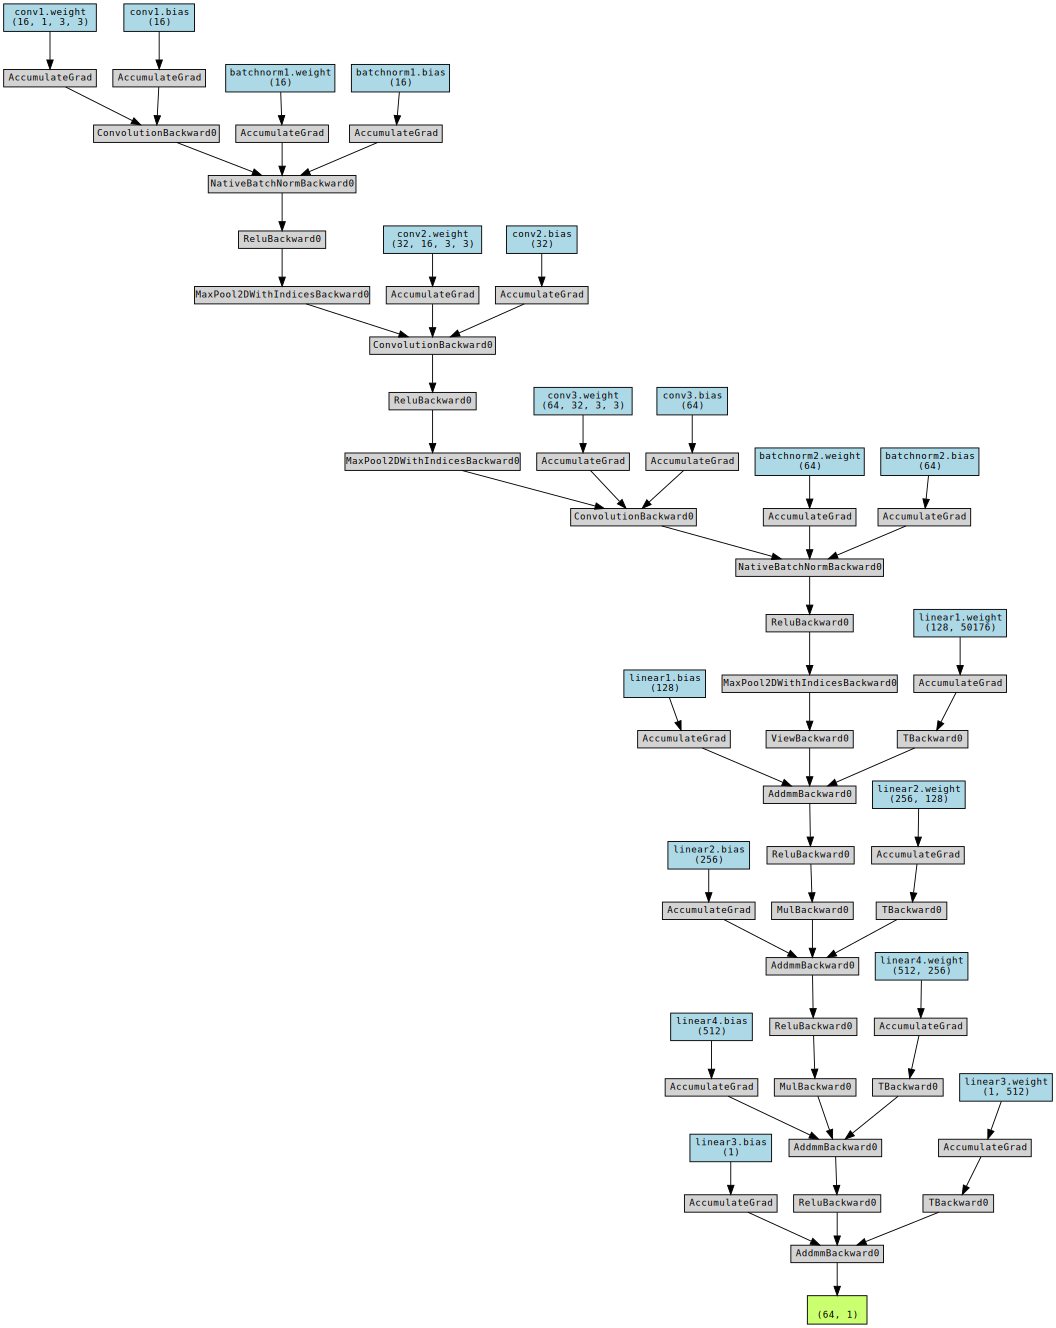

In [51]:
model=Net_2D()
img,label= next(iter(train_loader))
pred=model(img)
make_dot(pred , params=dict(list(model.named_parameters())))

In [32]:
from tqdm import tqdm
#Assembling images into a dataframe:
#Directory for bounding boxes:
bbx_dir='../input/bounding-boxes/Bounding Boxes/'
cases_bbx=os.listdir(bbx_dir)
cases_bbx=[os.path.join(bbx_dir,item) for item in cases_bbx]
columns=['Case','Image','Label']
polyp_data=pd.DataFrame(columns=columns)
for idx,item in tqdm(enumerate(cases_bbx)):
    
    case=cases_bbx[idx]
    case=case+'/'
    case_no=case.split('/')[4]
    if case_no in rest:
        label=0
    elif case_no in less_5:
        label=1
    else:
        continue
    images=os.listdir(case)
    images=[os.path.join(case,item) for item in images]
    for index in range(len(images)):
        temp_data=pd.DataFrame({
            'Case':[case_no],
            'Image': [images[index]],
            'Label':[label]
        })
        polyp_data=pd.concat([polyp_data,temp_data],ignore_index='True')

97it [01:17,  1.25it/s]


new_train_data=pd.DataFrame({
    "Case":[],
    "Image":[],
    "Label":[]
})
new_valid_data=pd.DataFrame({
    "Case":[],
    "Image":[],
    "Label":[]
})
for index in range(train_data.shape[0]):
    case_temp=train_data['Case'][index]
    image_temp=train_data['Image'][index]
    if case_temp in less_18:
        temp_label=1
        
    else:
        temp_label=0
    temp_data=pd.DataFrame({
        "Case":[case_temp],
        "Image":[image_temp],
        "Label":[temp_label]
    })
    new_train_data=pd.concat([new_train_data,temp_data],ignore_index='True')
    

for index in range(valid_data.shape[0]):
    case_temp=valid_data['Case'][index]
    image_temp=valid_data['Image'][index]
    if case_temp in less_18:
        temp_label=1
        
    else:
        temp_label=0
    temp_data=pd.DataFrame({
        "Case":[case_temp],
        "Image":[image_temp],
        "Label":[temp_label]
    })
    new_valid_data=pd.concat([new_valid_data,temp_data],ignore_index='True')
    

new_train_data['Label']=new_train_data['Label'].astype('uint8')
new_valid_data['Label']=new_valid_data['Label'].astype('uint8')

In [33]:
params={
    "device":'cuda' if torch.cuda.is_available() else 'cpu',
    "batch_size":64,
    "epochs":5,
    "lr":0.0001
    
}

In [34]:
import cv2
#Creating a custom dataloader:
polyp_path='../input/sun-polyps/Polyps/Polyps/'
tensor_pth='../input/sundepth224/Tensors/'
from  torch.utils.data import Dataset
class polyp_dataset(Dataset):
    def __init__(self,images_df):
        self.image_paths=images_df
    def __len__(self):
        return self.image_paths.shape[0]
    def get_labels(self):
        return self.image_paths['Label']
    def __getitem__(self,idx):
        img_path=self.image_paths['Image'][idx]
        img_name=img_path.split('/')[5]
        img_name=img_name.split('.')[0]
        img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(224,224))
        img=np.array(img,dtype='float32')
        case=self.image_paths['Case'][idx]
        
        tensor_cas=tensor_pth+case
        tensor_img=tensor_cas+'/'+img_name+'.pt'
        polyp_name=polyp_path+case+'/'+img_name+'.jpg'
        polyp_image=cv2.imread(polyp_name)
        polyp_image=cv2.cvtColor(polyp_image,cv2.COLOR_BGR2RGB)
        polyp_image=cv2.resize(polyp_image,(224,224))
        IMG=np.zeros((224,224))
        polyp_image=np.array(polyp_image,dtype=np.float32)
        polyp_image=polyp_image/255.
        #print(tensor_img)
        #print(img.shape)
        tensor_img=torch.load(tensor_img)
        tensor_img=tensor_img.numpy()
        for row in range(tensor_img.shape[0]):
            for col in range(tensor_img.shape[1]):
                if img[row][col]==255.0:
                    IMG[row][col]= tensor_img[row][col]
        tensor_img=IMG/255.0
        tensor_img=np.expand_dims(tensor_img,axis=0)
        
        #polyp_image=np.transpose(polyp_image,(2,0,1))
        
        tensor_img=torch.Tensor(tensor_img)
        
        #polyp_img=torch.Tensor(polyp_image)
        #final_img=torch.cat([polyp_img,tensor_img],dim=0)
        label=self.image_paths['Label'][idx]
        
        return tensor_img,label

In [35]:
#Creating train test and valid datasets
from sklearn.model_selection import train_test_split
Polyp_Train,Polyp_Valid=train_test_split(polyp_data,random_state=42,shuffle=True,test_size=0.2)
Polyp_Valid,Polyp_Test=train_test_split(Polyp_Valid,random_state=42,shuffle=True,test_size=0.5)

Polyp_Train.to_csv('Polyp_Train_Restart.csv')
Polyp_Valid.to_csv('Polyp_Valid_Restart.csv')

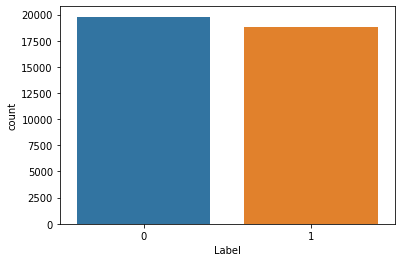

In [36]:
import seaborn as sns
sns.countplot(data=Polyp_Train,x='Label')
plt.show()

In [37]:
print('Length of Training Data: {}\nLength of Validation Data: {}'.format(Polyp_Train.shape[0],Polyp_Valid.shape[0]))

Length of Training Data: 38599
Length of Validation Data: 4825


In [38]:
#Reseting indices
Polyp_Train=Polyp_Train.reset_index()
Polyp_Train=Polyp_Train.drop(columns='index',axis=1)
#Polyp_Train=Polyp_Train.drop(columns='level_0',axis=1)
Polyp_Train.head()

,Case,Image,Label
0,case20,../input/bounding-boxes/Bounding Boxes/case20/...,1
1,case75,../input/bounding-boxes/Bounding Boxes/case75/...,1
2,case68,../input/bounding-boxes/Bounding Boxes/case68/...,0
3,case72,../input/bounding-boxes/Bounding Boxes/case72/...,1
4,case80,../input/bounding-boxes/Bounding Boxes/case80/...,0


In [39]:
Polyp_Test=Polyp_Test.reset_index()
Polyp_Test=Polyp_Test.drop(columns='index',axis=1)
#Polyp_Test=Polyp_Test.drop(columns='level_0',axis=1)
Polyp_Test.head()

,Case,Image,Label
0,case20,../input/bounding-boxes/Bounding Boxes/case20/...,1
1,case20,../input/bounding-boxes/Bounding Boxes/case20/...,1
2,case61,../input/bounding-boxes/Bounding Boxes/case61/...,0
3,case95,../input/bounding-boxes/Bounding Boxes/case95/...,0
4,case66,../input/bounding-boxes/Bounding Boxes/case66/...,0


In [40]:
Polyp_Valid=Polyp_Valid.reset_index()
Polyp_Valid=Polyp_Valid.drop(columns='index',axis=1)
#Polyp_Test=Polyp_Test.drop(columns='level_0',axis=1)
Polyp_Valid.head()

,Case,Image,Label
0,case41,../input/bounding-boxes/Bounding Boxes/case41/...,1
1,case50,../input/bounding-boxes/Bounding Boxes/case50/...,0
2,case65,../input/bounding-boxes/Bounding Boxes/case65/...,1
3,case71,../input/bounding-boxes/Bounding Boxes/case71/...,1
4,case44,../input/bounding-boxes/Bounding Boxes/case44/...,1


In [41]:
#Creating datasets
train_dataset=polyp_dataset(Polyp_Train)
test_dataset=polyp_dataset(Polyp_Test)
validation_dataset=polyp_dataset(Polyp_Valid)

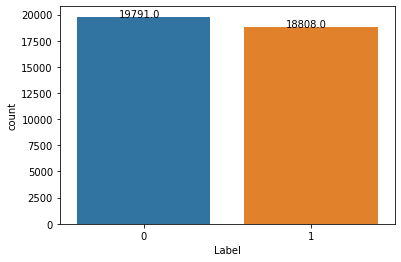

In [42]:
import seaborn as sns
ax=sns.countplot(data=Polyp_Train,x=Polyp_Train['Label'])
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

weights=[1./33366.0,1./5233.0]
samples_weight = np.array([weights[t] for t in Polyp_Train['Label']])
samples_weight = torch.from_numpy(samples_weight)
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [44]:
#Creating dataloaders
from torch.utils.data import DataLoader
train_loader=DataLoader(dataset=train_dataset,num_workers=2,pin_memory=True,batch_size=params['batch_size'])
test_loader=DataLoader(dataset=test_dataset,num_workers=2,pin_memory=True,shuffle=False,batch_size=params['batch_size'])
val_loader=DataLoader(dataset=validation_dataset,num_workers=2,pin_memory=True,shuffle=False,batch_size=params['batch_size'])

In [45]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        images=images.float()
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [46]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            images=images.float()
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [47]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [89]:
model=Net_2D()
model=model.cuda()
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [53]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
cudnn.benchmark = True

# Viewing some images with corresponding class...

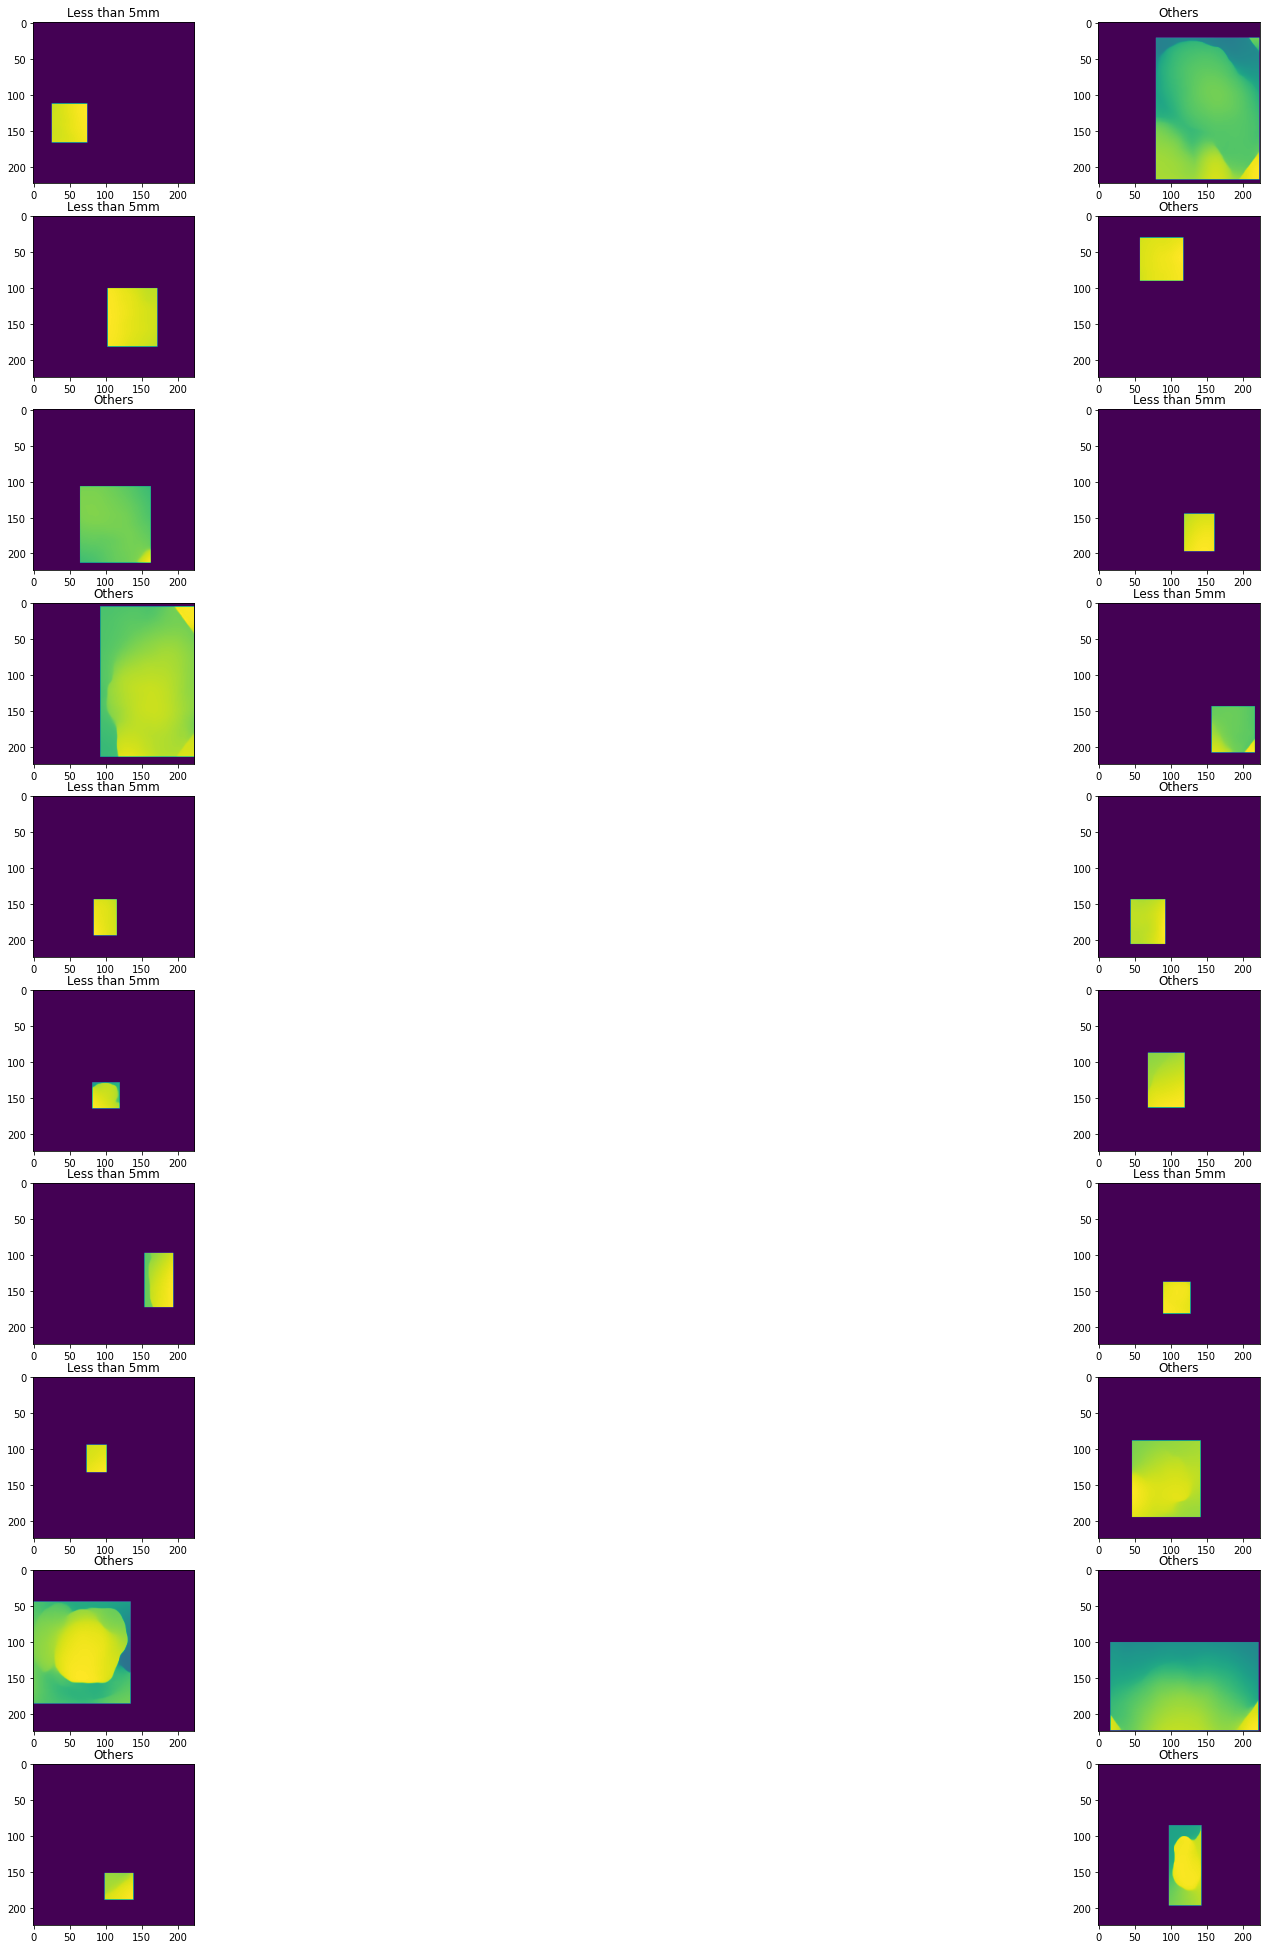

In [88]:
import matplotlib.pyplot
fig,axes=plt.subplots(10,2,figsize=(35,35))
axes=axes.flatten()
for index,data in enumerate(axes):
    img_temp=img[index]
    label_temp=label[index]
    img_temp=np.transpose(img_temp,(1,2,0))
    data.set_title('Less than 5mm'if label_temp==1 else 'Others')
    data.imshow(img_temp)
    
    img_temp=img[index+1]
    label_temp=label[index+1]
    img_temp=np.transpose(img_temp,(1,2,0))
    data.set_title('Less than 5mm'if label_temp==1 else 'Others')
    data.imshow(img_temp)
    

In [ ]:
#True
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    torch.save(model,'./CC_LAB_two_classes_5_vs_all.pt')
    torch.save(model.state_dict(),'./CC_LAB_two_classes_5_vs_all_st_dict.pt')
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.477 | Accuracy: 0.773: 100%|██████████| 604/604 [1:17:35<00:00,  7.71s/it]
Epoch: 1. Validation. Loss: 0.423 | Accuracy: 0.802: 100%|██████████| 76/76 [09:51<00:00,  7.79s/it]
Epoch: 2. Train.      Loss: 0.406 | Accuracy: 0.813: 100%|██████████| 604/604 [1:17:41<00:00,  7.72s/it]
Epoch: 2. Validation. Loss: 0.386 | Accuracy: 0.828: 100%|██████████| 76/76 [09:43<00:00,  7.68s/it]
Epoch: 3. Train.      Loss: 0.361 | Accuracy: 0.839: 100%|██████████| 604/604 [1:18:09<00:00,  7.76s/it]
Epoch: 3. Validation. Loss: 0.342 | Accuracy: 0.845: 100%|██████████| 76/76 [09:47<00:00,  7.73s/it]
Epoch: 4. Train.      Loss: 0.322 | Accuracy: 0.859: 100%|██████████| 604/604 [1:17:34<00:00,  7.71s/it]
Epoch: 4. Validation. Loss: 0.318 | Accuracy: 0.863: 100%|██████████| 76/76 [09:42<00:00,  7.67s/it]
Epoch: 5. Train.      Loss: 0.299 | Accuracy: 0.867:  44%|████▍     | 267/604 [34:13<42:54,  7.64s/it]  

In [ ]:
#True
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    torch.save(model,'./two_classes_5_vs_all.pt')
    torch.save(model.state_dict(),'./two_classes_5_vs_all_st_dict.pt')
    validate(val_loader, model, criterion, epoch, params)
    

In [ ]:
#True
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    torch.save(model,'./two_classes_10_vs_all.pt')
    torch.save(model.state_dict(),'./two_classes_10_vs_all_st_dict.pt')
    validate(val_loader, model, criterion, epoch, params)
    

In [ ]:
#True
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    torch.save(model,'./two_classes_14_vs_all.pt')
    torch.save(model.state_dict(),'./two_classes_14_vs_all_st_dict.pt')
    validate(val_loader, model, criterion, epoch, params)
    

In [ ]:
#True
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    torch.save(model,'./two_classes_18_vs_all.pt')
    torch.save(model.state_dict(),'./two_classes_18_vs_all_st_dict.pt')
    validate(val_loader, model, criterion, epoch, params)
    

In [ ]:
preds=[]
targets=[]
from tqdm import tqdm
with torch.no_grad():
    model.eval()
    for idx,data in tqdm(enumerate(val_loader)):
        img,label=data
        img=img.cuda()
        label=label.cuda()
        
        pred=model(img)
        
        preds.append(pred)
        targets.append(label)

In [ ]:
new_preds=[]

for item in range(len(preds)):
    for idx in range(len(preds[item])):
        ele=preds[item][idx].cpu()
        ele=torch.sigmoid(ele)
        if ele>=0.5:
            ele=1
        else:
            ele=0
        new_preds.append(ele)

In [ ]:
new_targets=[]


for item in range(len(targets)):
    for idx in range(len(targets[item])):
        ele=targets[item][idx].cpu()
        new_targets.append(ele)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(new_targets,new_preds)

In [ ]:
disp=ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()